In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
from sklearn.preprocessing import LabelEncoder
# Load the CSV file
df = pd.read_csv("data.csv", sep=';')

In [3]:
# fill all NaN values with -1. We are using -1 because, 0 is a valid value in this dataframe. 
df.fillna(-1, inplace=True)

In [4]:
def convert_float_int(val):
    if isinstance(val, float) and val.is_integer():
        return int(val)
    else:
        return val

df = df.map(convert_float_int) 


In [5]:

RES_min_len = 4
RES_max_len = 16

def valid_RES_length(df):
    return df['RES'].apply(lambda l: True if isinstance(l, int) and RES_min_len <= l <= RES_max_len else (-1 if l == -1 else False))


# This has a fixed lenght which is usually 2bytes
def valid_UESecCap_length(df):
    return df['UESecCap'].apply(lambda l: True if l == 2 else (-1 if l == -1 else False))


def is_valid_epd(df):
    return df['EPD'].apply(lambda epd: True if epd == 126 else (-1 if epd == -1 else False))


    

df['valid_epd'] = is_valid_epd(df)

df['UESecCap_length'] = valid_UESecCap_length(df)

df['RES_length'] = valid_RES_length(df)


In [7]:


def apply_flow_rules(df):
    valid_messages = {65, 66, 67, 68, 69, 70, 71, 72, 76, 77, 78, 79, 80, 81, 82,
                       83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 100, 
                       101, 102, 103, 104, 105, 106, 107, 108, 109 }
    
    

    list_of_messages_to_check = { 
        87: [65, 86,], # Authentication response
        94: [65, 86, 87, 93], # Security mode complete
        67: [65, 86, 87, 93, 94, 66], # Registration complete
        89: [65, 86,], # Authentication failure 
        103:[65, 86, 87, 93, 94, 66, 67], #  UL NAS transport
        92: [65, 86, 87, 93, 94, 91], #   Identity response
        69: [ #  Deregistration Request (UE originating). This can happen at any point in the network.
            [65, 86, 87], # early dereg
            [65, 86, 87, 93, 94, 66, 67, 103], # late dereg
            [65, 86, 87, 93, 94, 66, 67, 103, 84, 100], # complete dereg
            ],
        71: [65, 86, 87, 93, 94, 66, 67, 103], #   Deregistration request (UE terminated)
        77: [], # Service Reject
        85: [], # Configuration Update Complete
        76: [], # Service Request
        95: [], # Security Mode Reject
        90: [], # Authentication Result
    }

    memory = []
    seen_pairs = set()  # to store (Type, Type_2) pairs
    result = []

    for _, row in df.iterrows():
        current = int(row['Type']) if row['Type'] != -1 else -1
        type_2 = int(row['Type_2']) if row['Type_2'] != -1 and int(row['Type_2']) in valid_messages else -1


        if current not in valid_messages:
            result.append(False)
            continue

        # Reset memory if current == 65 (Registration Request)
        if current == 65:
            memory = []
            seen_pairs = set()

        # Check for duplicate (Type, Type_2) pair only if Type_2 is valid
        if type_2 != -1 and (current, type_2) in seen_pairs:
            print(f"Duplicate detected: (Type={current}, Type_2={type_2})")
            result.append(False)
            continue

        # Track seen (Type, Type_2) pair
        if type_2 != -1:
            seen_pairs.add((current, type_2))

        memory.append(current)
        print(f"Memory: {memory} | Current: {current} | Type_2: {type_2}")

        if current in list_of_messages_to_check:
            required_sequences = list_of_messages_to_check[current]
            memory_without_current = memory[:-1]

            # If multiple valid sequences (like for 69), check if any matches
            if isinstance(required_sequences[0], list):  # list of sequences
                match_found = any(memory_without_current == seq for seq in required_sequences)
                if match_found:
                    result.append(True)
                else:
                    print(f"Memory {memory_without_current} does NOT match any valid sequence for Type {current}.")
                    result.append(False)
            else:  # only one sequence to match
                if memory_without_current == required_sequences:
                    result.append(True)
                else:
                    print(f"Memory {memory_without_current} does NOT match required sequence {required_sequences}.")
                    result.append(False)
        else:
            result.append(True)

    return result



df['EPD']

df['FlowRuleResult'] = apply_flow_rules(df)
df['Label'] = (~(df['valid_epd'] & df['FlowRuleResult'] & df['RES_length'] & df['UESecCap_length'])).astype(int)
# df['Label'] = df['Label'].map({0: 'valid', 1: 'invalid'})




# df.to_csv("output.csv", index=False, sep=";")

Memory: [65] | Current: 65 | Type_2: -1
Memory: [65, 86] | Current: 86 | Type_2: -1
Memory: [65, 86, 87] | Current: 87 | Type_2: -1
Memory: [65, 86, 87, 93] | Current: 93 | Type_2: -1
Memory: [65, 86, 87, 93, 94] | Current: 94 | Type_2: 65
Duplicate detected: (Type=94, Type_2=65)
Memory: [65, 86, 87, 93, 94, 66] | Current: 66 | Type_2: -1
Memory: [65, 86, 87, 93, 94, 66, 67] | Current: 67 | Type_2: -1
Memory: [65, 86, 87, 93, 94, 66, 67, 103] | Current: 103 | Type_2: -1
Memory: [65, 86, 87, 93, 94, 66, 67, 103, 69] | Current: 69 | Type_2: -1
Memory: [65] | Current: 65 | Type_2: -1
Memory: [65, 86] | Current: 86 | Type_2: -1
Memory: [65, 86, 87] | Current: 87 | Type_2: -1
Memory: [65, 86, 87, 93] | Current: 93 | Type_2: -1
Memory: [65, 86, 87, 93, 94] | Current: 94 | Type_2: 65
Duplicate detected: (Type=94, Type_2=65)
Memory: [65, 86, 87, 93, 94, 66] | Current: 66 | Type_2: -1
Memory: [65, 86, 87, 93, 94, 66, 67] | Current: 67 | Type_2: -1
Memory: [65, 86, 87, 93, 94, 66, 67, 103] | Cur

### Data Splitting, Balancing, and Model Tuning

The dataset (extracted features with labels) is split into training, validation, and test sets using stratification on the labels (stratify=y). Stratification ensures that each split contains a balanced proportion of benign and malicious samples, preventing biased training or evaluation.

The splitting procedure is:

- Train (60%) and Temp (40%) split with stratify to maintain label balance.
- Temp is further split into Validation (20%) and Test (20%) sets (equal split), without stratification at this step.


In [21]:
from imblearn.over_sampling import RandomOverSampler
# 1. Separate features and labels
X = df.drop(['Label', 'AMF_UE_NGAP_ID', 'Time', 'ip_source', 'valid_epd', 'UESecCap_length', 'RES_length',
       'FlowRuleResult',], axis=1)

y = df['Label']

# 2. Split into Train (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# 3. Split Temp into Validation (20%) and Test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5,  random_state=42
)
# stratify=y_temp,


#### Addressing Class Imbalance with Oversampling

since there are few mailicious and more of begins data in the datasets, there will often be imbalanced labels. To prevent the model from biasing towards the majority class, the RandomOverSampler technique is applied to the training set, balancing the minority class (malicious). This balances the classes in the training set before model training.


In [22]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

Training set size: 493 (60.0%)
Validation set size: 164 (20.0%)
Test set size: 165 (20.1%)


#### Hyperparameter Tuning & Model Selection

To optimize model performance, two hyperparameter tuning methods are applied:

- Grid Search CV (exhaustive but slower)
- Randomized Search CV (random sampling of parameter space, faster)

Both use Stratified K-Fold cross-validation (5 folds) to ensure balanced splits during training and validation.

The Random Forest model hyperparameters tuned include:

- n_estimators: Number of trees in the forest.
- max_depth: Maximum depth of each tree.
- min_samples_split: Minimum number of samples required to split an internal node.
- min_samples_leaf: Minimum number of samples required to be at a leaf node.
- max_features: Number of features to consider when looking for the best split.
- bootstrap: Whether bootstrap samples are used when building trees.
- criterion: Function to measure the quality of a split 


In [23]:

# ============================================================================
# HYPERPARAMETER TUNING APPROACHES
# ============================================================================

# Approach 1: Grid Search (Exhaustive but slower)
print("\n" + "="*60)
print("APPROACH 1: GRID SEARCH")
print("="*60)

# Define hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialize model
rf = RandomForestClassifier(random_state=42, n_jobs=-1, 
                            n_estimators=50,
                            max_depth=3,
                            max_features='sqrt',
                            min_samples_leaf=2,
                            min_samples_split=20,
                            criterion='entropy',
                            bootstrap=False ,
                            class_weight={0: 1, 1: 10}, )

# Grid Search with Cross Validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search...")
start_time = time.time()
grid_search.fit(X_train_resampled, y_train_resampled)
grid_time = time.time() - start_time

print(f"Grid Search completed in {grid_time:.2f} seconds")
print(f"Best Grid Search Score: {grid_search.best_score_:.4f}")
print(f"Best Grid Search Parameters: {grid_search.best_params_}")

# Approach 2: Random Search (Faster, often just as good)
print("\n" + "="*60)
print("APPROACH 2: RANDOM SEARCH")
print("="*60)

# Define hyperparameter distribution for Random Search
param_dist = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 5, 8],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Random Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,  # Number of random combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Starting Random Search...")
start_time = time.time()
random_search.fit(X_train_resampled, y_train_resampled)
random_time = time.time() - start_time

print(f"Random Search completed in {random_time:.2f} seconds")
print(f"Best Random Search Score: {random_search.best_score_:.4f}")
print(f"Best Random Search Parameters: {random_search.best_params_}")



APPROACH 1: GRID SEARCH
Starting Grid Search...
Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Grid Search completed in 100.86 seconds
Best Grid Search Score: 0.9411
Best Grid Search Parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

APPROACH 2: RANDOM SEARCH
Starting Random Search...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random Search completed in 17.65 seconds
Best Random Search Score: 0.9411
Best Random Search Parameters: {'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}


#### Final Model Selection and Evaluation

After both searches complete, the model with the higher cross-validation (CV) accuracy is selected. This selected model is then evaluated on two additional datasets.

- Validation Set: Used to fine-tune the model if necessary.
- Test Set: Provides an unbiased estimate of the final model's performance on unseen data


In [24]:

# ============================================================================
# COMPARE RESULTS AND SELECT BEST MODEL
# ============================================================================

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Compare both approaches
if grid_search.best_score_ > random_search.best_score_:
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_method = "Grid Search"
else:
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    best_method = "Random Search"

print(f"Best method: {best_method}")
print(f"Best CV Score: {best_score:.4f}")
print(f"Best parameters: {best_params}")


# Evaluate on validation set
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Final evaluation on test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
# ============================================================================
# SAVE RESULTS
# ============================================================================

# Save the tuning results
tuning_results = {
    'grid_search_score': grid_search.best_score_,
    'grid_search_params': grid_search.best_params_,
    'grid_search_time': grid_time,
    'random_search_score': random_search.best_score_,
    'random_search_params': random_search.best_params_,
    'random_search_time': random_time,
    'best_method': best_method,
    'best_cv_score': best_score,
    'validation_accuracy': val_accuracy, 
    'test_accuracy': test_accuracy,
    'best_params': best_params
}

print(f"\nTuning completed! Grid Search took {grid_time:.2f}s, Random Search took {random_time:.2f}s")
print(f"Best model ({best_method}) achieved {test_accuracy:.4f} test accuracy")


MODEL COMPARISON
Best method: Random Search
Best CV Score: 0.9411
Best parameters: {'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
Validation Accuracy: 0.8963
Test Accuracy: 0.8364

Tuning completed! Grid Search took 100.86s, Random Search took 17.65s
Best model (Random Search) achieved 0.8364 test accuracy


In [25]:
# ============================================================================
# FINAL EVALUATION WITH BEST MODEL
# ============================================================================

print("\n" + "="*60)
print("FINAL MODEL EVALUATION")
print("="*60)

# Evaluate on validation set
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Final evaluation on test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


FINAL MODEL EVALUATION
Validation Accuracy: 0.8963
Test Accuracy: 0.8364

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91       164
           1       0.04      1.00      0.07         1

    accuracy                           0.84       165
   macro avg       0.52      0.92      0.49       165
weighted avg       0.99      0.84      0.91       165


Confusion Matrix:
[[137  27]
 [  0   1]]


In [26]:
# ============================================================================
# ANALYZE ANOMALIES IN TEST SET
# ============================================================================

print("\n" + "="*60)
print("ANOMALY ANALYSIS")
print("="*60)

# Get test set indices where label is 1 (anomaly)
anomaly_mask = y_test == 1
test_anomaly_indices = y_test[anomaly_mask].index

print(f"Number of anomalies in test set: {anomaly_mask.sum()}")
print(f"Percentage of anomalies in test set: {anomaly_mask.mean()*100:.2f}%")

# Show details of anomalies from original DataFrame
if len(test_anomaly_indices) > 0:
    print("\nAnomalies in test set:")
    anomaly_details = df.loc[test_anomaly_indices, ['AMF_UE_NGAP_ID', 'ip_source', 'Time', 'Label']]
    print(anomaly_details)
    
    # Show predictions for these anomalies
    anomaly_predictions = y_test_pred[anomaly_mask]
    correct_predictions = (y_test[anomaly_mask] == anomaly_predictions).sum()
    print(f"\nCorrectly predicted anomalies: {correct_predictions}/{len(test_anomaly_indices)} ({correct_predictions/len(test_anomaly_indices)*100:.1f}%)")
else:
    print("No anomalies found in test set")



ANOMALY ANALYSIS
Number of anomalies in test set: 1
Percentage of anomalies in test set: 0.61%

Anomalies in test set:
    AMF_UE_NGAP_ID     ip_source      Time  Label
15             459  10.63.112.69  0.047821      1

Correctly predicted anomalies: 1/1 (100.0%)


In [27]:
test_scores = best_model.predict_proba(X_test)[:, 1]

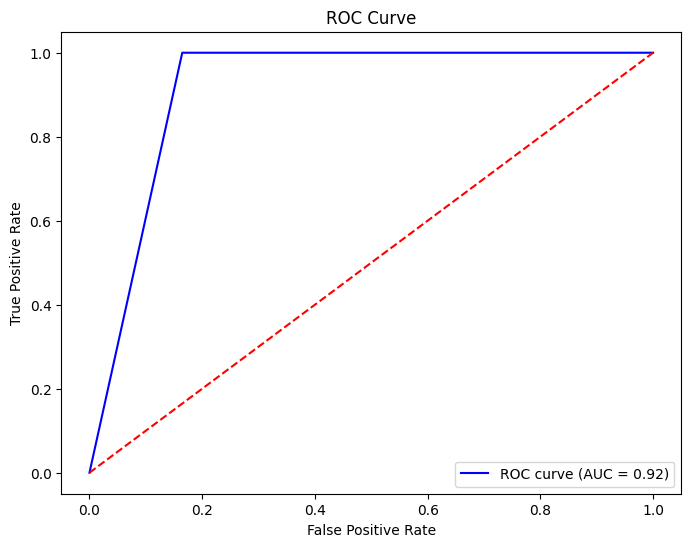

In [28]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, test_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


The curve sharply rises to the top-left corner, which means.
- The blue curve shows the model's ability to distinguish classes.
- The red dashed line represents random guess.
In summary, the ROC curve rises steeply with low FPR. it avoids misclassifying negatives. The AUC of 0.92 means it consistently ranks true positives higher than false positives. So, based on the ROC curve, the model is not misclassifying that much and is performing very well as expected.

In [58]:

# Feature importance (top 10)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))



Top 10 Most Important Features:
       feature  importance
20      Type_2    0.232617
18     spare_3    0.177864
3       SecHdr    0.120000
19    SecHdr_3    0.120000
17       EPD_3    0.098494
4         Type    0.081998
6   5GSRegType    0.076956
5      NAS_KSI    0.026793
8     UESecCap    0.012755
7        5GSID    0.012311


In [61]:
import joblib

# Save model and feature names together in a dictionary
joblib.dump({
    'model': best_model,
    'features': X.columns.tolist()  # save the column names used for training
}, 'rf_nas_classifier.pkl')


['rf_nas_classifier.pkl']

In [63]:
#